In [2]:
import numpy as np
import pandas as pd
from arch import arch_model
from hurst import compute_Hc
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import MetaTrader5 as mt5
import matplotlib.pyplot  as plt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from sklearn.linear_model import LinearRegression

from scipy.signal import find_peaks
from scipy.interpolate import interp1d


import hurst as hs


In [3]:
def obter_dados(symbol, n_barras=10000):

    # Inicializa o MT5
    if not mt5.initialize():
        print("Falha ao inicializar MT5")
        mt5.shutdown()
    else:
        print("MT5 inicializado com sucesso")

    rates = mt5.copy_rates_from_pos(symbol, mt5.TIMEFRAME_M15, 0, n_barras)
    df = pd.DataFrame(rates)
    df['Date'] = pd.to_datetime(df['time'], unit='s')
    df.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close'}, inplace=True)
    df = df[['Date','Open','High','Low','Close']]
    return df

def calculate_garch_bands(df):
    """
    Calcula bandas GARCH(1,1) SEM lookahead:
    - Retornos logarítmicos
    - Volatilidade GARCH até o final do dia anterior
    - Bandas diárias fixadas em 2 e 4 desvios
    
    Parâmetros:
    df : pd.DataFrame
        DataFrame com colunas 'Date' e 'Close'.
        
    Retorna:
    pd.DataFrame
        DataFrame com colunas adicionais:
        - Log_Returns
        - reference_price
        - daily_vol_garch
        - upper_garch_1d_2d, upper_garch_1d_4d
        - lower_garch_1d_2d, lower_garch_1d_4d
        - garch_mid_d
    """
    
    df = df.copy()
    
    # Converter data e calcular retornos logarítmicos
    df['time'] = pd.to_datetime(df['time'])
    df['Log_Returns'] = np.log(df['close'] / df['close'].shift(1))
    df.dropna(inplace=True)
    df['Day'] = df['time'].dt.to_period('D')
    
    # Lista de dias
    days = sorted(df['Day'].unique())
    
    all_bands = []
    
    for i, day in enumerate(days):
        if i == 0:
            continue  # Primeiro dia não tem referência anterior
        
        # Subconjunto até o final do dia anterior
        subset = df[df['Day'] <= days[i-1]]
        
        # Ajusta GARCH até o dia anterior
        garch_model = arch_model(subset['Log_Returns'] * 100, vol='Garch', p=1, q=1, dist='Normal')
        garch_result = garch_model.fit(disp="off")
        
        # Volatilidade condicional do último candle do dia anterior
        vol_last = garch_result.conditional_volatility.iloc[-1] / 100
        
        # Preço de fechamento do dia anterior
        ref_price = subset[subset['Day'] == days[i-1]]['close'].iloc[-1]
        
        # Cria bandas para todos os candles do dia atual
        day_data = df[df['Day'] == day].copy()
        day_data['reference_price_d'] = ref_price
        day_data['daily_vol_garch'] = vol_last
        
        for d in [2, 4]:
            day_data[f'upper_garch_1d_{d}d'] = (1 + d * vol_last) * ref_price
            day_data[f'lower_garch_1d_{d}d'] = (1 - d * vol_last) * ref_price
        
        day_data['garch_mid_d'] = (day_data['upper_garch_1d_2d'] + day_data['lower_garch_1d_2d']) / 2
        
        all_bands.append(day_data)
    
    # Concatenar resultados
    result = pd.concat(all_bands)
   # result.set_index("time", inplace=True)
    
    return result

def calculate_garch_bands_weekly(df):
    """
    Calcula bandas GARCH(1,1) SEM lookahead:
    - Retornos logarítmicos
    - Volatilidade GARCH até o final da semana anterior
    - Bandas semanais fixadas em 2 e 4 desvios
    
    Parâmetros:
    df : pd.DataFrame
        DataFrame com colunas 'Date' e 'Close'.
        
    Retorna:
    pd.DataFrame
        DataFrame com colunas adicionais:
        - Log_Returns
        - reference_price
        - weekly_vol_garch
        - upper_garch_1w_2d, upper_garch_1w_4d
        - lower_garch_1w_2d, lower_garch_1w_4d
        - garch_mid_w
    """
    df = df.copy()
    
    # Converter datas e calcular retornos
    df['time'] = pd.to_datetime(df['time'])
    df['Log_Returns'] = np.log(df['close'] / df['close'].shift(1))
    df.dropna(inplace=True)
    df['Week'] = df['time'].dt.to_period('W')  # Agrupamento semanal
    
    # Lista de semanas
    weeks = sorted(df['Week'].unique())
    
    all_bands = []
    
    for i, week in enumerate(weeks):
        if i == 0:
            continue  # Primeira semana não tem referência anterior
        
        # Subconjunto até o fim da semana anterior
        subset = df[df['Week'] <= weeks[i-1]]
        
        # Ajusta GARCH até semana anterior
        garch_model = arch_model(subset['Log_Returns'] * 100, vol='Garch', p=1, q=1, dist='Normal')
        garch_result = garch_model.fit(disp="off")
        
        # Volatilidade condicional do último candle da semana anterior
        vol_last = garch_result.conditional_volatility.iloc[-1] / 100
        
        # Preço de fechamento do último candle da semana anterior
        ref_price = subset[subset['Week'] == weeks[i-1]]['close'].iloc[-1]
        
        # Cria bandas para todos os candles da semana atual
        week_data = df[df['Week'] == week].copy()
        week_data['reference_price_w'] = ref_price
        week_data['weekly_vol_garch'] = vol_last
        
        for d in [2, 4, 6]:
            week_data[f'upper_garch_1w_{d}d'] = (1 + d * vol_last) * ref_price
            week_data[f'lower_garch_1w_{d}d'] = (1 - d * vol_last) * ref_price
        
        week_data['garch_mid_w'] = (week_data['upper_garch_1w_2d'] + week_data['lower_garch_1w_2d']) / 2
        
        all_bands.append(week_data)
    
    # Concatenar resultados
    result = pd.concat(all_bands)    
    return result

def Calculate_Hurst(df, var, window_size, ser_type):
    """
    Calculates the hurst exponent for the var:variable in df:dataset for given rolling window size
    ser_type: gives the type of series. It can be of three types:
        'change':      a series is just random values (i.e. np.random.randn(...))
        'random_walk': a series is a cumulative sum of changes (i.e. np.cumsum(np.random.randn(...)))
        'price':       a series is a cumulative product of changes (i.e. np.cumprod(1+epsilon*np.random.randn(...))
    """
    hurst = [np.nan] * (window_size-1)
    var_values = list(df[var])
    for i in range(0, len(var_values)-(window_size-1)):
        H, c, data = hs.compute_Hc(var_values[i:i+window_size], kind=ser_type, simplified=True)
        hurst.append(H)
    df['hurst_'+str(window_size)] = hurst
    return df

In [4]:
df_all = pd.read_csv('datasets/df_all.csv')
df_all = df_all.rename(columns={"Date": "time"})
df_all['time'] = pd.to_datetime(df_all['time'])

In [5]:
df_all.ticker.unique()

array(['ABEV3', 'ASAI3', 'B3SA3', 'BBSE3', 'BBDC3', 'BBDC4', 'BBAS3',
       'BRAV3', 'BPAC11', 'CMIG4', 'COGN3', 'CPLE6', 'CSAN3', 'CYRE3',
       'ELET3', 'EMBR3', 'ENGI11', 'ENEV3', 'EQTL3', 'GGBR4', 'HAPV3',
       'HYPE3', 'ITSA4', 'ITUB4', 'KLBN11', 'RENT3', 'LREN3', 'MGLU3',
       'POMO4', 'MBRF3', 'MOTV3', 'MULT3', 'NATU3', 'PETR3', 'PETR4',
       'PRIO3', 'RADL3', 'RDOR3', 'RAIL3', 'SBSP3', 'CSNA3', 'SUZB3',
       'VIVT3', 'TIMS3', 'TOTS3', 'UGPA3', 'VALE3', 'VBBR3', 'WEGE3'],
      dtype=object)

In [6]:
df1 = df_all[df_all["ticker"] == "PETR4"]
df1 = df1.dropna()
df1.drop('ticker',axis=1,inplace=True)
df1.reset_index(drop=True, inplace=True)

In [7]:
'''df1 = pd.read_csv('BTCUSDT_1D_BINANCE_FUTURES.csv')
df1.drop(['Unnamed: 0', 'close_time', 'open_time'], axis=1, inplace=True)
df1.time = pd.to_datetime(df1.time)'''

"df1 = pd.read_csv('BTCUSDT_1D_BINANCE_FUTURES.csv')\ndf1.drop(['Unnamed: 0', 'close_time', 'open_time'], axis=1, inplace=True)\ndf1.time = pd.to_datetime(df1.time)"

## Target

In [8]:
df = df1.copy()
#df = df[:1000]

In [9]:
peak_value = 1
threshold_pct = 1

In [10]:
# CRIAÇÃO DA TARGET

# CRIANDO PEAKS
peaks = None
troughs = None
x_peaks = None
y_peaks = None
x_troughs = None
y_troughs = None

df['peaks'] = np.nan
df['troughs'] = np.nan

# Identificar topos e fundos
peaks, _ = find_peaks(df['close'], distance=peak_value)
troughs, _ = find_peaks(-df['close'], distance=peak_value)

# Preencher valores reais nos pontos
df.loc[peaks, 'peaks'] = df['close'].iloc[peaks]
df.loc[troughs, 'troughs'] = df['close'].iloc[troughs]

# Interpolação linear entre os picos
if len(peaks) > 1:
    f_peaks = interp1d(peaks, df['close'].iloc[peaks], kind='linear', fill_value="extrapolate")
    df['peaks'] = f_peaks(np.arange(len(df)))
else:
    # Apenas um pico, preenche com ele
    df['peaks'] = df['close'].iloc[peaks[0]]

# Interpolação linear entre os fundos
if len(troughs) > 1:
    f_troughs = interp1d(troughs, df['close'].iloc[troughs], kind='linear', fill_value="extrapolate")
    df['troughs'] = f_troughs(np.arange(len(df)))
else:
    df['troughs'] = df['close'].iloc[troughs[0]]


# INDICADOR INCLINAÇÃO
df['pct_peaks'] = df.peaks.pct_change() * 10000
df['pct_troughs'] = df.troughs.pct_change() * 10000



# TARGET
df['target'] = np.where(
    (df['pct_peaks'] >= threshold_pct) & (df['pct_troughs'] >= threshold_pct),  # condição de alta
    1,
    np.where(
        (df['pct_peaks'] <= -threshold_pct) & (df['pct_troughs'] <= -threshold_pct),  # condição de baixa
        -1,
        0  # neutra
    )
)


In [11]:
import plotly.graph_objects as go
import numpy as np
df.set_index('time',inplace=True)
fig = go.Figure()

# Inicializar arrays
targets = df['target'].values
start_idx = 0

# Criar segmentos contínuos de cores
for i in range(1, len(targets)):
    if targets[i] != targets[start_idx]:
        # Determinar cor do segmento
        color = 'black'  # neutro
        if targets[start_idx] == 1:
            color = 'green'
        elif targets[start_idx] == -1:
            color = 'red'
        
        fig.add_trace(go.Scatter(
            x=df.index[start_idx:i],
            y=df['close'].iloc[start_idx:i],
            mode='lines',
            line=dict(color=color),
            showlegend=False
        ))
        start_idx = i

# Último segmento
color = 'black'
if targets[start_idx] == 1:
    color = 'green'
elif targets[start_idx] == -1:
    color = 'red'

fig.add_trace(go.Scatter(
    x=df.index[start_idx:],
    y=df['close'].iloc[start_idx:],
    mode='lines',
    line=dict(color=color),
    showlegend=False
))

# Layout
fig.update_layout(
    title="WINFUT Close Price",
    xaxis_title="Tempo",
    yaxis_title="Preço",
    template="plotly_white",
    hovermode="x unified",
    height=600
)

fig.show()
df.reset_index(inplace=True)

In [12]:
df2 = df.copy()

## Features

In [13]:
df = df2.copy()
df.drop('peaks', axis=1, inplace=True)
df.drop('troughs', axis=1, inplace=True)
df.drop('pct_peaks', axis=1, inplace=True)
df.drop('pct_troughs', axis=1, inplace=True)

In [14]:
# AVAT
df['return'] = df['close'].pct_change()

# Média móvel do volume
df['AvgVolume'] = df['volume'].rolling(window=20).mean()

# AVAT = Volume atual / Média móvel do volume
df['AVAT'] = df['volume'] / df['AvgVolume']

In [15]:
# GARCH 
df = calculate_garch_bands_weekly(df)

df.drop('Week', axis=1,inplace=True)

# (Close - garch mid) / (close - ref_price)
df['distance_w'] =  (df.close - df.garch_mid_w) / df.garch_mid_w

df['distance_w_17_mean'] = df.distance_w.rolling(17).mean()
df['distance_w_72_mean'] = df.distance_w.rolling(72).mean()

c:\Users\rodrigo\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\volatility.py:1215: RuntimeWarning:

invalid value encountered in scalar divide

c:\Users\rodrigo\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\distribution.py:449: RuntimeWarning:

divide by zero encountered in log

c:\Users\rodrigo\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\distribution.py:449: RuntimeWarning:

invalid value encountered in divide

c:\Users\rodrigo\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\distribution.py:449: RuntimeWarning:

divide by zero encountered in divide

c:\Users\rodrigo\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\distribution.py:449: RuntimeWarning:

invalid value encountered in add

c:\Users\rodrigo\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning:

The optimizer returned code 4. The message 

In [16]:
# HURST
hurst_windows = [100, 150, 200, 250, 300, 400]

# Calculate hurst exponents for given window sizes
for i in range(0, len(hurst_windows)):
    df = Calculate_Hurst(df, 'close', hurst_windows[i], 'price')

In [17]:
df3 = df.copy()

## Modeling

In [18]:
# === 1. Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import xgboost as xgb

In [57]:
df = df3.copy()
#df.set_index('time', inplace=True)

#### Division data

In [58]:
df = df.iloc[400:]
df['target'] = df['target'].replace(-1, 2)

#X = df.drop(columns=['target', 'time'], errors='ignore').select_dtypes(include=['number'])
#y = df['target']

In [59]:
feature_cols = ['open', 'high', 'low', 'close', 'volume', 'return', 'AvgVolume', 'AVAT', 'Log_Returns',
                'reference_price_w', 'weekly_vol_garch', 'upper_garch_1w_2d', 'lower_garch_1w_2d', 
                'upper_garch_1w_4d', 'lower_garch_1w_4d', 'garch_mid_w', 'distance_w', 'distance_w_17_mean', 
                'distance_w_72_mean', 'hurst_100', 'hurst_150', 'hurst_200', 'hurst_250', 'hurst_300', 'hurst_400']


In [60]:
# Division
df['time'] = pd.to_datetime(df['time'])

# === 2. Split temporal ===
train_mask = (df['time'] >= '2000-01-01') & (df['time'] <= '2023-12-31')
test_mask  = (df['time'] >= '2023-01-01') & (df['time'] <= '2025-12-31')

df_train = df.loc[train_mask].copy().reset_index(drop=True)
df_test  = df.loc[test_mask].copy().reset_index(drop=True)

# === 3. Features e Target ===
X_train = df_train[feature_cols]
y_train = df_train['target']

X_test  = df_test[feature_cols]
y_test  = df_test['target']

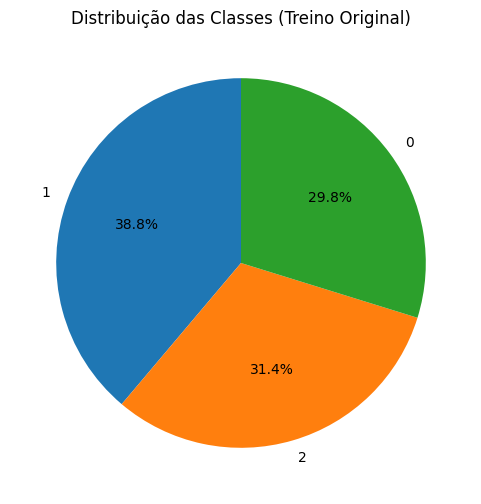

In [61]:
plt.figure(figsize=(6,6))
plt.pie(y_train.value_counts(), labels=y_train.value_counts().index, autopct='%1.1f%%', startangle=90)
plt.title("Distribuição das Classes (Treino Original)")
plt.show()

#### XGBoost

In [62]:
class_weights = {0: 1, 1: 1, 2: 1}

c:\Users\rodrigo\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning:

[01:35:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




=== Relatório de Classificação ===
              precision    recall  f1-score   support

           0       0.73      0.40      0.52       204
           1       0.72      0.82      0.77       290
           2       0.63      0.80      0.71       195

    accuracy                           0.69       689
   macro avg       0.69      0.68      0.67       689
weighted avg       0.70      0.69      0.68       689



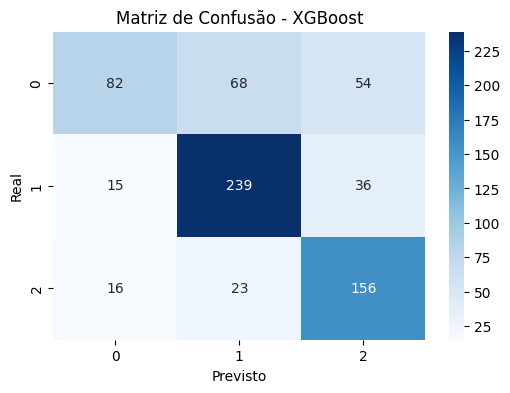

In [63]:
# === 4. Pesos das classes ===
classes = np.unique(y_train)

# Exemplo de pesos (ajuste conforme necessidade)

sample_weights = np.array([class_weights[y] for y in y_train])

# === 5. Modelo XGBoost ===
model = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=3,
    eval_metric="mlogloss",
    use_label_encoder=False,
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Treinar modelo
model.fit(X_train, y_train, sample_weight=sample_weights)

# Previsões
df_test['pred'] = model.predict(X_test)

# === 6. Avaliação ===
print("=== Relatório de Classificação ===")
print(classification_report(df_test['target'], df_test['pred']))

cm = confusion_matrix(df_test['target'], df_test['pred'])

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão - XGBoost")
plt.show()

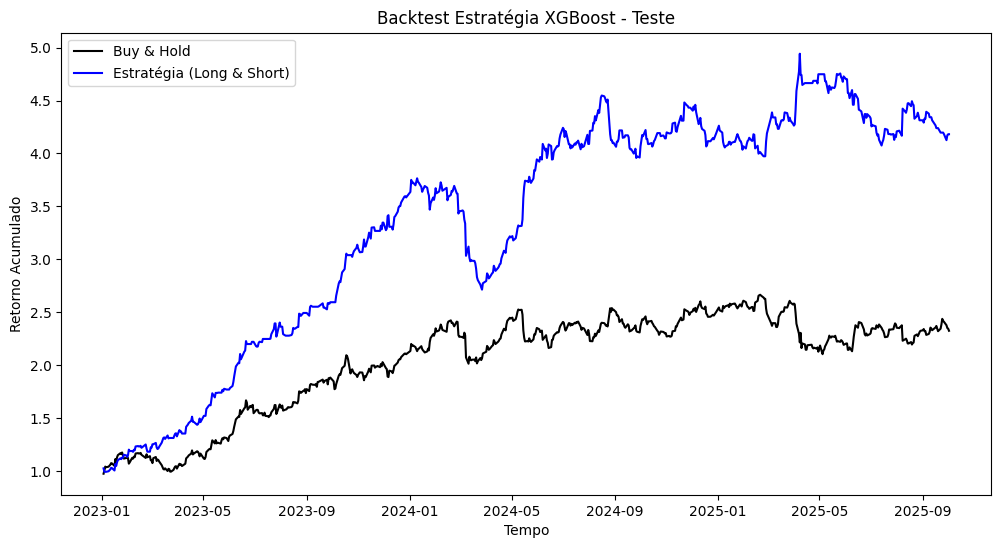

Retorno total da estratégia: 318.19%
Sharpe ratio aproximado: 2.26
Taxa de acerto (dias positivos): 45.43%


In [64]:
import matplotlib.pyplot as plt
import numpy as np

# Garantir que preços estão ordenados por tempo
df_test = df_test.sort_values('time').reset_index(drop=True)

# Calcular retornos do ativo
df_test['returns'] = df_test['close'].pct_change()

# Definir posição da estratégia
df_test['position'] = 0
df_test.loc[df_test['pred'] == 1, 'position'] = 1   # Long
df_test.loc[df_test['pred'] == 2, 'position'] = -1  # Short

# Evitar lookahead bias (shift para só operar no próximo dia)
df_test['position'] = df_test['position'].shift(1).fillna(0)

# Retorno da estratégia
df_test['strategy_return'] = df_test['position'] * df_test['returns']

# Retornos acumulados
df_test['cum_asset'] = (1 + df_test['returns']).cumprod()
df_test['cum_strategy'] = (1 + df_test['strategy_return']).cumprod()

# === Plot Backtest ===
plt.figure(figsize=(12,6))
plt.plot(df_test['time'], df_test['cum_asset'], label='Buy & Hold', color='black')
plt.plot(df_test['time'], df_test['cum_strategy'], label='Estratégia (Long & Short)', color='blue')
plt.title("Backtest Estratégia XGBoost - Teste")
plt.xlabel("Tempo")
plt.ylabel("Retorno Acumulado")
plt.legend()
plt.show()

# === Métricas ===
total_return = df_test['cum_strategy'].iloc[-1] - 1
sharpe_ratio = df_test['strategy_return'].mean() / df_test['strategy_return'].std() * np.sqrt(252)
hit_ratio = (df_test['strategy_return'] > 0).mean()

print(f"Retorno total da estratégia: {total_return:.2%}")
print(f"Sharpe ratio aproximado: {sharpe_ratio:.2f}")
print(f"Taxa de acerto (dias positivos): {hit_ratio:.2%}")


In [65]:
class_weights = {0: 1, 1: 1, 2: 1}

c:\Users\rodrigo\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning:

[01:35:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.




=== Relatório de Classificação ===
              precision    recall  f1-score   support

           0       0.81      0.27      0.41       204
           1       0.68      0.87      0.76       290
           2       0.63      0.82      0.71       195

    accuracy                           0.68       689
   macro avg       0.71      0.65      0.63       689
weighted avg       0.71      0.68      0.65       689



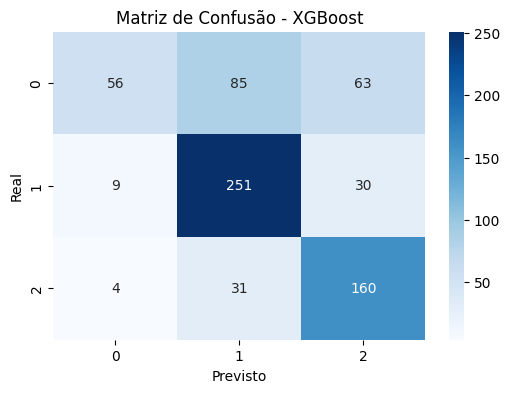

In [66]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Classes únicas
classes = np.unique(y_train)

# Pesos manuais
sample_weights = np.array([class_weights[y] for y in y_train])

# Criar modelo XGBoost com hiperparâmetros adicionais
model = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=3,
    eval_metric="mlogloss",
    use_label_encoder=False,
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=10,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=1,
    reg_alpha=0.1,
    reg_lambda=0.01,
    random_state=42
)

# Treinar modelo
model.fit(X_train, y_train, sample_weight=sample_weights)

# Prever no teste
y_pred = model.predict(X_test)

# Adicionar previsões no df_test
df_test['pred'] = y_pred

# === Avaliação ===
print("=== Relatório de Classificação ===")
print(classification_report(y_test, y_pred))

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão - XGBoost")
plt.show()


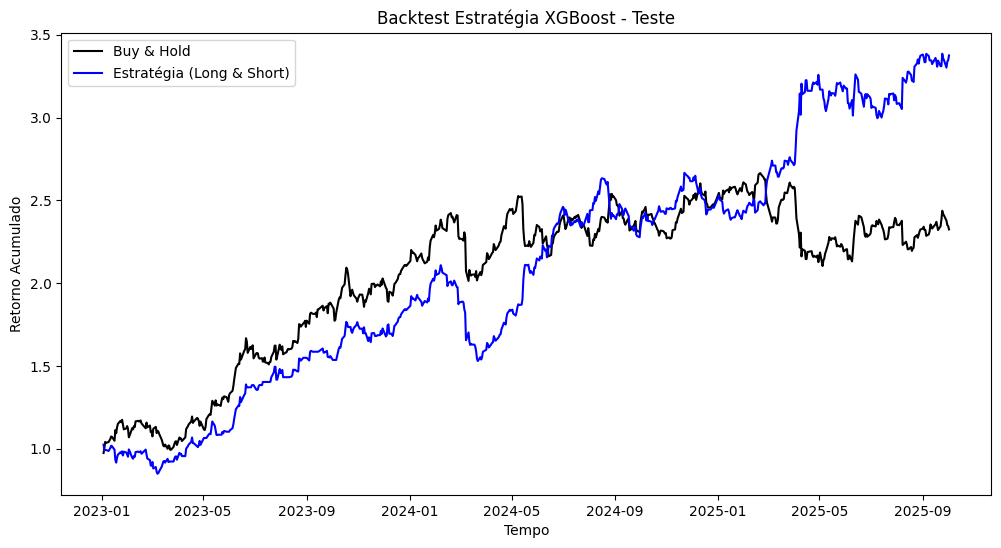

Retorno total da estratégia: 237.54%
Sharpe ratio aproximado: 1.87
Taxa de acerto (dias positivos): 48.33%


In [67]:
import matplotlib.pyplot as plt
import numpy as np

# Garantir que preços estão ordenados por tempo
df_test = df_test.sort_values('time').reset_index(drop=True)

# Calcular retornos do ativo
df_test['returns'] = df_test['close'].pct_change()

# Definir posição da estratégia
df_test['position'] = 0
df_test.loc[df_test['pred'] == 1, 'position'] = 1   # Long
df_test.loc[df_test['pred'] == 2, 'position'] = -1  # Short

# Evitar lookahead bias (shift para só operar no próximo dia)
df_test['position'] = df_test['position'].shift(1).fillna(0)

# Retorno da estratégia
df_test['strategy_return'] = df_test['position'] * df_test['returns']

# Retornos acumulados
df_test['cum_asset'] = (1 + df_test['returns']).cumprod()
df_test['cum_strategy'] = (1 + df_test['strategy_return']).cumprod()

# === Plot Backtest ===
plt.figure(figsize=(12,6))
plt.plot(df_test['time'], df_test['cum_asset'], label='Buy & Hold', color='black')
plt.plot(df_test['time'], df_test['cum_strategy'], label='Estratégia (Long & Short)', color='blue')
plt.title("Backtest Estratégia XGBoost - Teste")
plt.xlabel("Tempo")
plt.ylabel("Retorno Acumulado")
plt.legend()
plt.show()

# === Métricas ===
total_return = df_test['cum_strategy'].iloc[-1] - 1
sharpe_ratio = df_test['strategy_return'].mean() / df_test['strategy_return'].std() * np.sqrt(252)
hit_ratio = (df_test['strategy_return'] > 0).mean()

print(f"Retorno total da estratégia: {total_return:.2%}")
print(f"Sharpe ratio aproximado: {sharpe_ratio:.2f}")
print(f"Taxa de acerto (dias positivos): {hit_ratio:.2%}")


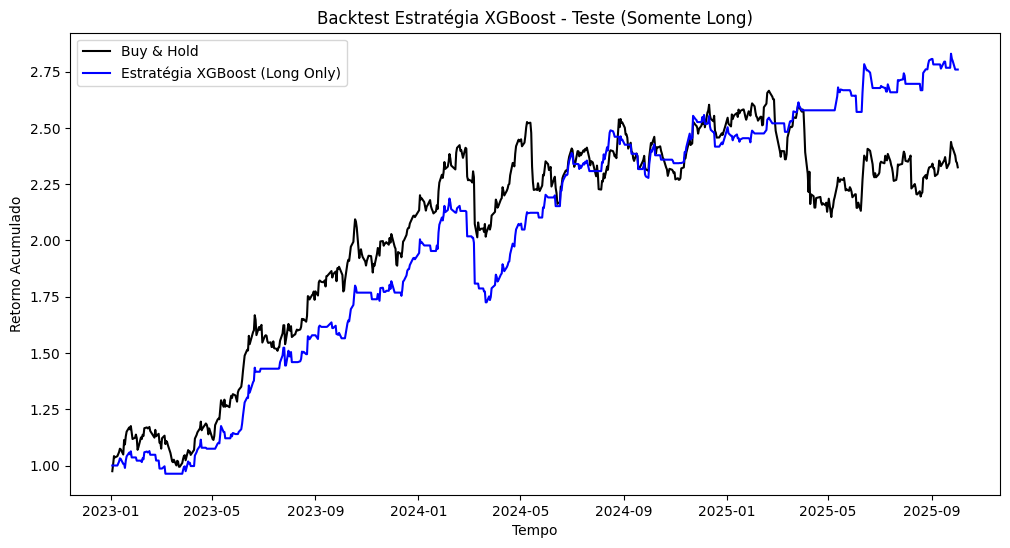

Retorno total da estratégia: 175.95%
Sharpe ratio aproximado: 2.05
Taxa de acerto (dias positivos): 29.46%


In [68]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Garantir ordenação temporal
df_test = df_test.sort_values('time').reset_index(drop=True)

# Calcular retorno diário do ativo
df_test['returns'] = df_test['close'].pct_change()

# Definir posição da estratégia (Long Only: pred == 1)
df_test['position'] = 0
df_test.loc[df_test['pred'] == 1, 'position'] = 1   # Long
# Evitar lookahead bias
df_test['position'] = df_test['position'].shift(1).fillna(0)

# Retorno da estratégia
df_test['strategy_return'] = df_test['position'] * df_test['returns']

# Retornos acumulados
df_test['cum_asset'] = (1 + df_test['returns']).cumprod()
df_test['cum_strategy'] = (1 + df_test['strategy_return']).cumprod()

# Plot do backtest
plt.figure(figsize=(12,6))
plt.plot(df_test['time'], df_test['cum_asset'], label='Buy & Hold', color='black')
plt.plot(df_test['time'], df_test['cum_strategy'], label='Estratégia XGBoost (Long Only)', color='blue')
plt.title("Backtest Estratégia XGBoost - Teste (Somente Long)")
plt.xlabel("Tempo")
plt.ylabel("Retorno Acumulado")
plt.legend()
plt.show()

# Métricas de performance
total_return = df_test['cum_strategy'].iloc[-1] - 1
sharpe_ratio = df_test['strategy_return'].mean() / df_test['strategy_return'].std() * np.sqrt(252)
hit_ratio = (df_test['strategy_return'] > 0).mean()

print(f"Retorno total da estratégia: {total_return:.2%}")
print(f"Sharpe ratio aproximado: {sharpe_ratio:.2f}")
print(f"Taxa de acerto (dias positivos): {hit_ratio:.2%}")


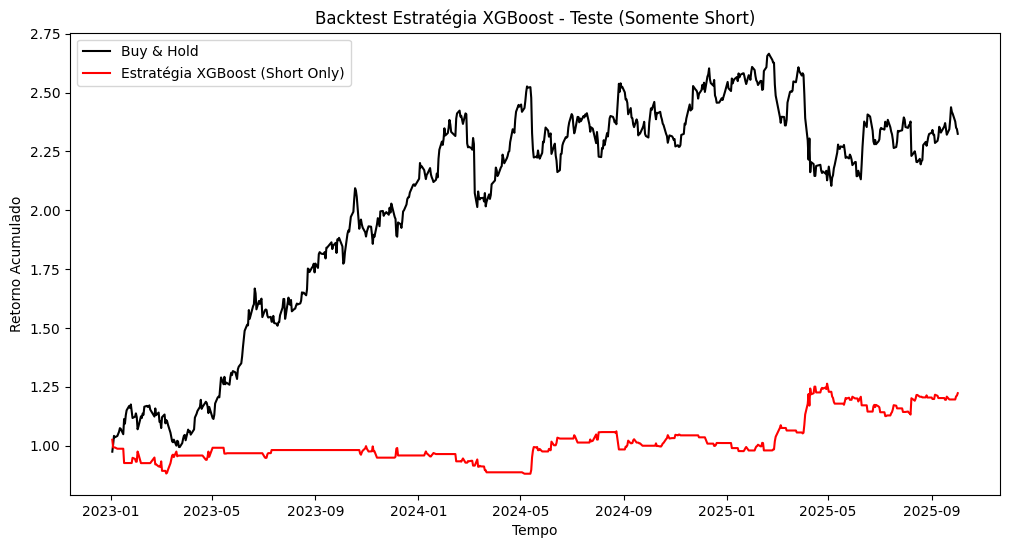

Retorno total da estratégia: 22.32%
Sharpe ratio aproximado: 0.52
Taxa de acerto (dias positivos): 18.87%


In [69]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Garantir ordenação temporal
df_test = df_test.sort_values('time').reset_index(drop=True)

# Calcular retorno diário do ativo
df_test['returns'] = df_test['close'].pct_change()

# Definir posição da estratégia (Short Only: pred == 2)
df_test['position'] = 0
df_test.loc[df_test['pred'] == 2, 'position'] = -1   # Short
# Evitar lookahead bias
df_test['position'] = df_test['position'].shift(1).fillna(0)

# Retorno da estratégia
df_test['strategy_return'] = df_test['position'] * df_test['returns']

# Retornos acumulados
df_test['cum_asset'] = (1 + df_test['returns']).cumprod()
df_test['cum_strategy'] = (1 + df_test['strategy_return']).cumprod()

# Plot do backtest
plt.figure(figsize=(12,6))
plt.plot(df_test['time'], df_test['cum_asset'], label='Buy & Hold', color='black')
plt.plot(df_test['time'], df_test['cum_strategy'], label='Estratégia XGBoost (Short Only)', color='red')
plt.title("Backtest Estratégia XGBoost - Teste (Somente Short)")
plt.xlabel("Tempo")
plt.ylabel("Retorno Acumulado")
plt.legend()
plt.show()

# Métricas de performance
total_return = df_test['cum_strategy'].iloc[-1] - 1
sharpe_ratio = df_test['strategy_return'].mean() / df_test['strategy_return'].std() * np.sqrt(252)
hit_ratio = (df_test['strategy_return'] > 0).mean()

print(f"Retorno total da estratégia: {total_return:.2%}")
print(f"Sharpe ratio aproximado: {sharpe_ratio:.2f}")
print(f"Taxa de acerto (dias positivos): {hit_ratio:.2%}")
